# Trabalho 05 - Classificação

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from  scipy.stats import chi2_contingency
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split
from AnalysisUtils import print_simple_metrics, boxplot_with_quartiles, create_filtered_histograms
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, cohen_kappa_score, accuracy_score, precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
import warnings
import seaborn as sns
from scipy.stats import ttest_rel
import shap

warnings.filterwarnings('ignore')

In [ ]:
def load_data():
    return pd.read_csv('data/trabalho5_dados_4.csv')

def preprocess_data(df, categorical_columns, inputting_method):
    # display(((df == 'MD') | df.isna()).sum())
    df = df.replace('MD', np.nan)
    df = fill_missing_data(df, method=inputting_method)

    df['Quantitative Ability 1'] = df['Quantitative Ability 1'].astype(float)
    df['Analytical Skills 1'] = df['Analytical Skills 1'].astype(float)
    df['Domain Skills 1'] = df['Domain Skills 1'].astype(float)

    df['Year of Birth'] = df['Year of Birth'].map(lambda x: x[1:]).astype(int)
    df['10th Completion Year'] = df['10th Completion Year'].map(
        lambda x: x[1:]).astype(int)
    df['12th Completion year'] = df['12th Completion year'].map(
        lambda x: x[1:]).astype(int)
    df[' Year of Completion of college'] = df[' Year of Completion of college'].map(
        lambda x: x[1:]).astype(int)

    df.rename(columns={
              ' Year of Completion of college': 'Year of Completion of college'}, inplace=True)
    df.rename(columns={' 10th percentage': '10th percentage'}, inplace=True)
    df.rename(columns={' 12th percentage': '12th percentage'}, inplace=True)
    df.rename(
        columns={' College percentage': 'College percentage'}, inplace=True)
    df.rename(columns={' English 1': 'English 1'}, inplace=True)

    df = encode_string_columns(df, categorical_columns)

    # As linhas estão realmentes duplicadas (Candidate ID iguais)
    # duplicates = df[df.duplicated(keep='first') | df.duplicated(keep='last')]
    # duplicates = duplicates.sort_values(by='Candidate ID')
    # display(HTML(duplicates.to_html()))

    df = df.drop_duplicates(df, keep='first')  # Removeu 55 duplicatas

    return df

def fill_missing_data(df, method='knn', n_neighbors=5):
    if method == 'simple':
        for col in df.columns:
            if df[col].dtype in ['float64', 'int64']:
                df[col] = df[col].fillna(df[col].mean())
            else:
                if df[col].notna().any():
                    df[col] = df[col].fillna(df[col].mode()[0])

    elif method == 'knn':
        # Separate numeric and non-numeric columns
        df_numeric = df.select_dtypes(include=['float64', 'int64'])
        df_non_numeric = df.select_dtypes(exclude=['float64', 'int64'])

        # Apply get_dummies for non-numeric columns to perform one-hot encoding
        df_non_numeric_dummies = pd.get_dummies(
            df_non_numeric, drop_first=False)

        # Impute using KNN
        imputer_numeric = KNNImputer(n_neighbors=n_neighbors)
        imputer_non_numeric = KNNImputer(n_neighbors=1)

        df_imputed_numeric = pd.DataFrame(
            imputer_numeric.fit_transform(df_numeric),
            columns=df_numeric.columns,
            index=df_numeric.index
        )

        df_imputed_non_numeric = pd.DataFrame(
            imputer_non_numeric.fit_transform(df_non_numeric_dummies),
            columns=df_non_numeric_dummies.columns,
            index=df_non_numeric_dummies.index
        )
        # Reverse the one-hot encoding by getting the most frequent category for each column
        df_non_numeric_imputed = pd.DataFrame(
            index=df_imputed_non_numeric.index)
        for col in df_non_numeric.columns:
            vals_col = df_non_numeric[col].dropna().unique()

            dummies = [col + '_' + str(val) for val in vals_col]
            dummies_values = df_imputed_non_numeric[dummies].idxmax(
                axis=1).apply(lambda x: x.split('_')[-1])
            df_non_numeric_imputed[col] = dummies_values

        # Combine numeric and non-numeric back to the original DataFrame
        df = pd.concat([df_imputed_numeric, df_non_numeric_imputed], axis=1)

    else:
        raise ValueError("Invalid method. Choose from 'simple' or 'knn'.")

    return df

def encode_string_columns(df, categorical_columns: list[str]):
    for col in categorical_columns:
        # Get the unique values in the column
        unique_values = df[col].dropna().unique()

        if col == 'Gender':
            df['dummy_Gender'] = df[col].str.lower().map({'a': 0, 'b': 1})
            continue

        if col == 'Month of Birth':
            df['dummy_Month of Birth'] = df[col].str.lower().map({
                'jan': 0,
                'feb': 1,
                'mar': 2,
                'apr': 3,
                'may': 4,
                'jun': 5,
                'jul': 6,
                'aug': 7,
                'sep': 8,
                'oct': 9,
                'nov': 10,
                'dec': 11,
            })
            continue

        if col == 'Performance':
            df['Performance_classification'] = df[col].str.lower().map(
                {'lp': 0, 'mp': 0, 'bp': 1})
            continue

        if len(unique_values) == 2:
            label_encoder = LabelEncoder()
            df[f"dummy_{col}"] = label_encoder.fit_transform(df[col])
            continue
        else:
            df_dummies = pd.get_dummies(df[col], prefix=f"dummy_{col}")
            df = pd.concat([df, df_dummies], axis=1)
            continue

    return df

def detect_outliers_by_iiq(df, numerical_columns):
    outlier_counts = {}

    for col in numerical_columns:
        col_values = df[col].dropna()
        q1, q3 = np.percentile(col_values, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        outlier_counts[col] = ((df[col] < lower_bound) |
                               (df[col] > upper_bound)).sum()

    return pd.Series(outlier_counts)

def plot_all_category_columns(df, category_columns, class_column=None, top=10):
    num_columns = len(category_columns)
    rows = (num_columns // 3) + (num_columns % 3 > 0)
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    axes = axes.flatten()

    for idx, column in enumerate(category_columns):
        ax = axes[idx]

        if class_column:
            # Group by both the category and class column
            result_df = df.groupby([column, class_column]).size().reset_index(name='Count')
            result_df = result_df.sort_values(by='Count', ascending=False)
            top_values = result_df[column].value_counts().index[:top]
            result_df = result_df[result_df[column].isin(top_values)]

            # Use seaborn to create a color-coded bar plot
            sns.barplot(data=result_df, x=column, y='Count', hue=class_column, ax=ax)
            ax.legend(title=class_column)
        else:
            # Get the value counts for the column
            result_df = df[column].value_counts().reset_index()
            result_df.columns = [column, 'Count']
            result_df['Percentage'] = (result_df['Count'] / result_df['Count'].sum()) * 100
            result_df = result_df.head(top)

            # Plot the bar chart
            sns.barplot(data=result_df, x=column, y='Count', ax=ax, color='skyblue')

            for i, (count, pct) in enumerate(zip(result_df['Count'], result_df['Percentage'])):
                ax.text(i, count + 0.5, f'{count} / {pct:.1f}%', ha='center', va='bottom')

        ax.set_title(f"Value Counts of {column}", fontsize=12, pad=20)
        ax.set_xlabel('Values', fontsize=10)
        ax.set_ylabel('Count', fontsize=10)
        ax.tick_params(axis='x', rotation=45)

    # Remove any empty axes
    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.tight_layout()
    plt.show()

def create_smooth_histograms(df, numerical_column, class_column, bins=100, log=False):
    print(f"\n--------------------------------------\n")
    print(f"Histograms for column {numerical_column} by {class_column} with bins: {bins}")

    plt.figure(figsize=(10, 5))

    # Plot separate distributions for each class in class_column
    unique_classes = df[class_column].dropna().unique()
    colors = sns.color_palette("husl", len(unique_classes))

    for class_value, color in zip(unique_classes, colors):
        class_data = df[df[class_column] == class_value][numerical_column]
        sns.histplot(class_data, bins=bins, kde=True, color=color, log_scale=log, alpha=0.5, label=f"{class_column}: {class_value}")

    plt.legend()
    plt.xlabel(numerical_column)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {numerical_column} by {class_column}")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

    print(f"\n--------------------------------------\n")

def analyze_all_numerical_columns(df, numerical_columns, class_column):
    for numerical_column in numerical_columns:
        analyze_numerical_column(df, numerical_column, class_column)

def analyze_numerical_column(df, numerical_column, class_column):
    print_simple_metrics(df[numerical_column])
    boxplot_with_quartiles(df[numerical_column], yscale='linear')
    create_smooth_histograms(df, numerical_column=numerical_column, class_column=class_column, bins=100)

def correlation_heatmap(df, numerical_columns):
    plt.figure(figsize=(10, 8))  # Set figure size
    sns.heatmap(df[numerical_columns].corr(), annot=True,
                cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title("Correlação dos Atributos")
    plt.show()

def categorical_correlation_chi_square(df, categorical_columns):
    corr_matrix = pd.DataFrame(np.ones((len(categorical_columns), len(categorical_columns))),
                               index=categorical_columns, columns=categorical_columns)

    for col1 in categorical_columns:
        for col2 in categorical_columns:
            if col1 != col2:
                corr_matrix.loc[col1, col2] = chi_square_p_value(
                    df[col1], df[col2])

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',
                fmt=".4f", linewidths=0.5)
    plt.title("Categorical Correlation Heatmap (Chi-Square p-values)")
    plt.show()

def chi_square_p_value(x, y):
    contingency_table = pd.crosstab(x, y)
    _, p, _, _ = chi2_contingency(contingency_table)
    return p

def scale_data(df, columns):
    scaler = StandardScaler()
    new_df = df.copy()
    new_df[columns] = scaler.fit_transform(df[columns])
    return new_df

def pca_analysis(df, columns, plot=True):
    # Performing PCA
    pca_df = df[columns].copy()
    pca = PCA()
    pca_data = pca.fit_transform(pca_df)
    for i in range(pca_data.shape[1]):
        pca_df[f'pca{i+1}'] = pca_data[:, i]

    # Loading components
    loadings = pd.DataFrame(
        pca.components_,
        columns=pca_df.columns[:pca.components_.shape[-1]],
        index=[f'PCA{i + 1}' for i in range(pca.n_components_)]
    )

    # Explained variance ratio and PCA contributions
    explained_variance_ratio = pca.explained_variance_ratio_
    pca_contributions = (explained_variance_ratio[:5]).round(4)

    if plot:
        plt.figure(figsize=(8, 6))
        plt.scatter(pca_df['pca1'], pca_df['pca2'], s=50)
        plt.title("PCA Clustering")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.show()

    sorted_loadings = {}
    for i in range(pca.n_components_):
        pca_component = f'PCA{i + 1}'
        top_contributors = loadings.iloc[i].abs(
        ).sort_values(ascending=False).head(5)

        # Create a dictionary for the top contributors and their contributions
        sorted_loadings[pca_component] = {
            feature: top_contributors[feature] for feature in top_contributors.index
        }

    return pca_df, sorted_loadings, pca_contributions

def pca_explained_variance_plot(df, columns):
    pca_df = df[columns].copy()
    pca = PCA()
    pca_data = pca.fit_transform(pca_df)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = explained_variance_ratio.cumsum()

    # Plot the cumulative explained variance vs the number of principal components
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_explained_variance) + 1),
             cumulative_explained_variance, marker='o', linestyle='-')
    plt.title("Cumulative Explained Variance vs. Number of Principal Components")
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance (%)")
    plt.xticks(range(1, len(explained_variance_ratio) + 1))
    plt.yticks([i / 10 for i in range(0, 11)])
    plt.grid(True)
    plt.show()

    # Now, let's calculate and plot the contribution of each original column to the total variance explained
    loadings = pd.DataFrame(
        pca.components_,
        columns=pca_df.columns[:pca.components_.shape[-1]],
        index=[f'PCA{i + 1}' for i in range(pca.n_components_)]
    )

    # Calculate the contribution of each original feature across all principal components
    feature_contributions = loadings.abs().sum(axis=0).sort_values(ascending=False)

    plt.figure(figsize=(12, 8))  # Set larger figure size
    feature_contributions.plot(
        kind='bar', stacked=True, colormap='viridis', figsize=(12, 8))
    plt.title("Feature Contribution to PCA Components",
              fontsize=16, fontweight='bold')
    plt.xlabel("Original Features", fontsize=12)
    plt.ylabel("Total Contribution to PCA Components", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return cumulative_explained_variance, feature_contributions

def train_classifier(df, model, columns, y_column, test_size=0.3):
    X = df[columns]
    y = df[y_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

def stratified_k_fold_cross_validation(df, model, columns, y_column, k=10, scale=False):
    steps = []
    if scale:
        steps.append(('scaler', StandardScaler()))
    steps.append(('classifier', model))
    pipeline = Pipeline(steps)

    # Define stratified k-fold
    stratified_kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Define Kappa as scoring metric
    kappa_scorer = make_scorer(cohen_kappa_score)

    # Perform cross-validation
    scores = cross_val_score(pipeline, df[columns], df[y_column], cv=stratified_kf, scoring=kappa_scorer)

    return scores

In [ ]:
numerical_columns = [
    '10th percentage',
    '12th percentage',
    'College percentage',
    'English 1',
    'English 2',
    'English 3',
    'English 4',
    'Quantitative Ability 1',
    'Quantitative Ability 2',
    'Quantitative Ability 3',
    'Quantitative Ability 4',
    'Domain Skills 1',
    'Domain Skills 2',
    'Domain Test 3',
    'Domain Test 4',
    'Analytical Skills 1',
    'Analytical Skills 2',
    'Analytical Skills 3', 
    'Year of Birth',
    '10th Completion Year',
    '12th Completion year',
    'Year of Completion of college'
]

categorical_columns = [
    'Month of Birth',
    'Gender',
    'State (Location)',
    'Degree of study',
    'Specialization in study'
]

ignored_columns = [
    'Candidate ID',
    'Name',
    'Number of characters in Original Name'
]

y_column = 'Performance_classification'
y_columns = ['Performance', y_column]

In [ ]:
original_df = load_data()
original_df

In [ ]:
df = preprocess_data(original_df, categorical_columns + ['Performance'], inputting_method='knn')
df

In [ ]:
df[['Performance_classification', 'Performance']]

In [ ]:
dummy_columns = [column for column in df.columns if column not in (numerical_columns + ignored_columns + y_columns + categorical_columns)]
dummy_columns

In [ ]:
detect_outliers_by_iiq(df, numerical_columns)

In [ ]:
plot_all_category_columns(df, categorical_columns, class_column='Performance_classification', top=40)

In [ ]:
len(df)

In [ ]:
analyze_all_numerical_columns(df, numerical_columns, class_column='Performance_classification')

In [ ]:
correlation_heatmap(df, numerical_columns)

In [ ]:
categorical_correlation_chi_square(df, numerical_columns + categorical_columns)

In [ ]:
scaled_df = scale_data(df, numerical_columns + dummy_columns)
scaled_df

In [ ]:
pca_df, loadings, pca_contributions = pca_analysis(scaled_df, columns=numerical_columns + dummy_columns)

print(f"contribuiçoes de cada pca: {pca_contributions}")
loadings

In [ ]:
cumulative_explained_variance, feature_contributions = pca_explained_variance_plot(scaled_df, columns=numerical_columns + dummy_columns)

In [ ]:
pca_df = pca_df[[f"pca{i}"for i in range(1, 40)]]
pca_df

In [ ]:
classification_columns = numerical_columns + dummy_columns
classification_columns

## stratified K fold cross validation with Train test split 70 - 30 

In [ ]:
def evaluate_models(df, models, columns, y_column, pipelines=None, k=5):
    results = []
    stratified_kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    unique_classes = sorted(df[y_column].unique())
    class_counts = df[y_column].value_counts(normalize=True) * 100

    pbar = tqdm(models.items(), desc="Evaluating models")
    
    # Loop through models
    for model_name, model in pbar:
        pbar.set_description(f"Processing {model_name}")
        
        for pipeline_name, pipeline_func in (pipelines or {}).items():
            print(f"initializing: {pipeline_name}")
            kappa_scores, accuracies = [], []
            per_class_precision = {c: [] for c in unique_classes}
            per_class_recall = {c: [] for c in unique_classes}

            # Stratified K-fold loop
            for train_idx, test_idx in stratified_kf.split(df, df[y_column]):
                X_train, X_test = df.iloc[train_idx], df.iloc[test_idx]
                y_train, y_test = df.iloc[train_idx][y_column], df.iloc[test_idx][y_column]

                X_train, X_test, new_cols = pipeline_func(X_train, X_test, columns)

                # Fit the model to the training data
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                # Store the results
                kappa_scores.append(cohen_kappa_score(y_test, y_pred))
                accuracies.append(accuracy_score(y_test, y_pred))

                precision, recall, _, _ = precision_recall_fscore_support(y_test, y_pred, labels=unique_classes, zero_division=0)

                for i, c in enumerate(unique_classes):
                    per_class_precision[c].append(precision[i])
                    per_class_recall[c].append(recall[i])

            # Add suffix for the applied pipeline
            model_result = {
                'Model': model_name,
                'pipeline': pipeline_name,
                'Mean Kappa Score': np.mean(kappa_scores),
                'Std Kappa Score': np.std(kappa_scores),
                'Mean Accuracy': np.mean(accuracies),
                'Std Accuracy': np.std(accuracies)
            }

            # Add per-class precision and recall to the result
            for c in unique_classes:
                model_result[f'Precision Class {c}'] = np.mean(per_class_precision[c])
                model_result[f'Recall Class {c}'] = np.mean(per_class_recall[c])
                model_result[f'Class {c} Representation (%)'] = class_counts.get(c, 0)

            results.append(model_result)

    return pd.DataFrame(results)

def evaluate_random_forest_with_shap(df, columns, pipeline, y_column, test_size=0.2, random_state=42):
    """
    Trains a Random Forest model, evaluates it using SHAP, and plots feature importance as a vertical bar plot.
    """
    # Extract the target variable
    y = df[y_column]

    # Apply the pipeline to transform the data
    df_transformed, _, transformed_columns = pipeline(df, df, columns)
    X = df_transformed[transformed_columns]
    print(f"Dimensionality: {len(transformed_columns)}")

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Train a Random Forest model
    model = RandomForestClassifier(n_estimators=100, random_state=random_state)
    model.fit(X_train, y_train)

    # Get feature importances
    importances = model.feature_importances_
    feature_names = transformed_columns

    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]

    # Plot feature importance as a vertical bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.title("Feature Importance from Random Forest")
    plt.tight_layout()
    plt.show()

    # Create a SHAP explainer using X_train
    explainer = shap.Explainer(model, X_train)

    # Calculate SHAP values for X_train
    shap_values = explainer(X_train, check_additivity=False)

    # For binary classification, select SHAP values for the positive class (class 1)
    if len(shap_values.shape) == 3:  # Multi-class
        shap_values_selected = shap_values.values[:, :, 1]  # Select SHAP values for the positive class
    else:  # Binary or regression
        shap_values_selected = shap_values.values

    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values_selected, X_train, feature_names=transformed_columns)
    plt.title("SHAP Summary Plot for All Features (X_train)")
    plt.show()

    return model, explainer, shap_values

def plot_model_results(df):
    """
    Given a dataframe with columns including:
    'Model', 'pipeline', 'Mean Kappa Score', 'Std Kappa Score', 'Mean Accuracy', 'Std Accuracy',
    'Precision Class 0', 'Recall Class 0', 'Precision Class 1', 'Recall Class 1',
    this function:
      1. Sorts models by Mean Kappa Score and selects the top 10 and bottom 10.
      2. Creates bar plots for Mean Kappa Score and Mean Accuracy (both sorted separately).
      3. Creates a sorted bar chart with two bars per model for Precision and Recall of Class 0.
    """

    # Create a unique identifier for each approach
    df["Approach"] = df["Model"] + " - " + df["pipeline"]

    # ---- Sorting by Mean Kappa Score ----
    df_sorted_kappa = df.sort_values(by="Mean Kappa Score", ascending=False)
    df_top10_kappa = df_sorted_kappa.head(10)
    df_bottom10_kappa = df_sorted_kappa.tail(10)
    df_kappa = pd.concat([df_top10_kappa, df_bottom10_kappa])

    # ---- Sorting by Mean Accuracy ----
    df_sorted_accuracy = df.sort_values(by="Mean Accuracy", ascending=False)
    df_top10_accuracy = df_sorted_accuracy.head(10)
    df_bottom10_accuracy = df_sorted_accuracy.tail(10)
    df_accuracy = pd.concat([df_top10_accuracy, df_bottom10_accuracy])

    # ---- PLOT 1: Bar plot for Mean Kappa Score (Top & Bottom 10, sorted) ----
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_kappa, x='Approach', y='Mean Kappa Score', palette="viridis_r")
    plt.xticks(rotation=30, ha='right')
    plt.title("Top & Bottom 10 Models: Mean Kappa Score (Sorted)")
    plt.tight_layout()
    plt.show()

    # ---- PLOT 2: Bar plot for Mean Accuracy (Top & Bottom 10, sorted) ----
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_accuracy, x='Approach', y='Mean Accuracy', palette="viridis_r")
    plt.xticks(rotation=30, ha='right')
    plt.title("Top & Bottom 10 Models: Mean Accuracy (Sorted)")
    plt.tight_layout()
    plt.show()

    # ---- PLOT 3: Sorted Bar Chart for Precision & Recall (Class 0) ----
    df_sorted_prec_recall = df_kappa.sort_values(by=['Precision Class 0'], ascending=False)
    plt.figure(figsize=(12, 6))

    df_melted_prec_recall = df_sorted_prec_recall.melt(id_vars=['Approach'],
                                                       value_vars=['Precision Class 0', 'Recall Class 0'],
                                                       var_name='Metric', value_name='Value')

    sns.barplot(data=df_melted_prec_recall, x='Approach', y='Value', hue='Metric', palette=["#440154", "#FDE725"])

    plt.xticks(rotation=30, ha='right')
    plt.title("Top & Bottom 10 Models: Precision & Recall for Class 0 (Sorted)")
    plt.tight_layout()
    plt.show()


In [ ]:
def scale_df(X_train, X_test, columns):
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    
    scaler = StandardScaler()
    scaler.fit(X_train[columns])
    
    X_train_scaled[columns] = scaler.transform(X_train[columns])
    X_test_scaled[columns] = scaler.transform(X_test[columns])
    
    return X_train_scaled[columns], X_test_scaled[columns], columns

def scale_and_pca_with_elbow(X_train, X_test, columns, explained_variance_threshold=0.95):
    X_train_scaled, X_test_scaled, columns = scale_df(X_train, X_test, columns)
    

    pca = PCA()
    pca.fit(X_train_scaled[columns])

    elbow = 1
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)
    if cumulative_explained_variance[elbow - 1] < explained_variance_threshold:
        elbow = np.argmax(cumulative_explained_variance >= explained_variance_threshold) + 1

    pca_cols = [f"pca{i}"for i in range(1, elbow+1)]

    pca = PCA(n_components=elbow)
    pca.fit(X_train_scaled[columns])
    X_train_pca_data = pca.transform(X_train_scaled[columns])
    X_test_pca_data = pca.transform(X_test_scaled[columns])
    
    for i, pca_col in enumerate(pca_cols):
        X_train_scaled[pca_col] = X_train_pca_data[:, i]
        X_test_scaled[pca_col] = X_test_pca_data[:, i]

    return X_train_scaled[pca_cols],  X_test_scaled[pca_cols], pca_cols

def filter_low_representation_columns(X_train, X_test, columns, threshold=0.01):
    X_train_copy = X_train.copy()
    binary_cols = X_train_copy[columns].select_dtypes(include=['uint8', 'int64']).columns
    new_cols = []
    for col in binary_cols:
        ones_percentage = X_train_copy[col].mean()
        if ones_percentage >= threshold:
            new_cols.append(col)
    
    dropped_cols = set(binary_cols) - set(new_cols)
    new_columns = list(set(columns) - dropped_cols)
    
    # print(f"Dropped a total of: {len(columns) - len(new_columns)}") 
    return X_train_copy[new_columns], X_test[new_columns], new_columns

def smooth_target_encoding(X_train, X_test, columns, smoothing=1):
    encoded_X_train = X_train.copy()
    encoded_X_test = X_test.copy()
    global_mean = encoded_X_train[y_column].mean()
    target_cols = ['Specialization in study', 'State (Location)']
    keywords = [f'dummy_{col}' for col in target_cols]
    filtered_columns = [col for col in columns if not any(keyword in col for keyword in keywords)]
    
    for col in target_cols:
        means = encoded_X_train.groupby(col)[y_column].mean()
        counts = encoded_X_train.groupby(col)[y_column].count()

        smoothed_values = {
            value: (means[value] * counts[value] + global_mean * smoothing) / (counts[value] + smoothing)
            for value in means.index
        }
    
        # Apply smoothing formula
        encoded_X_train[col] = encoded_X_train[col].map(smoothed_values)
        encoded_X_test[col] = encoded_X_test[col].map(smoothed_values).fillna(global_mean)
        
        
    final_cols = filtered_columns + target_cols
        
    return encoded_X_train[final_cols], encoded_X_test[final_cols], final_cols

def combined1(X_train, X_test, columns):
    X_train_copy, X_test_copy, new_cols = smooth_target_encoding(X_train, X_test, columns)
    X_train_copy, X_test_copy, new_cols = scale_df(X_train_copy, X_test_copy, new_cols)
    return X_train_copy, X_test_copy, new_cols

def combined2(X_train, X_test, columns):
    X_train_copy, X_test_copy, new_cols = smooth_target_encoding(X_train, X_test, columns)
    X_train_copy, X_test_copy, new_cols = scale_and_pca_with_elbow(X_train_copy, X_test_copy, new_cols)
    return  X_train_copy, X_test_copy, new_cols

def combined3(X_train, X_test, columns):
    X_train_copy, X_test_copy, new_cols = smooth_target_encoding(X_train, X_test, columns)
    X_train_copy, X_test_copy, new_cols = scale_and_pca_with_elbow(X_train_copy, X_test_copy, new_cols)
    X_train_copy, X_test_copy, new_cols = filter_low_representation_columns(X_train_copy, X_test_copy, new_cols)
    return X_train_copy, X_test_copy, new_cols

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'SVC': SVC(kernel='rbf', C=1.0),
    'GaussianNB': GaussianNB(),
    'KNeighbors': KNeighborsClassifier(n_neighbors=5),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100),
    'MLPClassifier': MLPClassifier(hidden_layer_sizes=(1000,), max_iter=10000),
}

pipelines = {
    '': lambda X_train, X_test, columns: (X_train[columns], X_test[columns], columns),
    'scale': scale_df, 
    'pca': scale_and_pca_with_elbow,
    'filter_cols': filter_low_representation_columns,
    'smooth_target_encoding': smooth_target_encoding,
    'ste + scale': combined1,
    'ste + scale + pca': combined2,
    'ste + scale + pca + filter': combined3
    
}

In [ ]:
results = evaluate_models(df, models, classification_columns, y_column, pipelines=pipelines, k=5)
results

In [ ]:
results.to_csv('model_tests_results.csv')

In [ ]:
model_results_df = pd.read_csv('model_tests_results.csv')
model_results_df

Dimensionality: 30


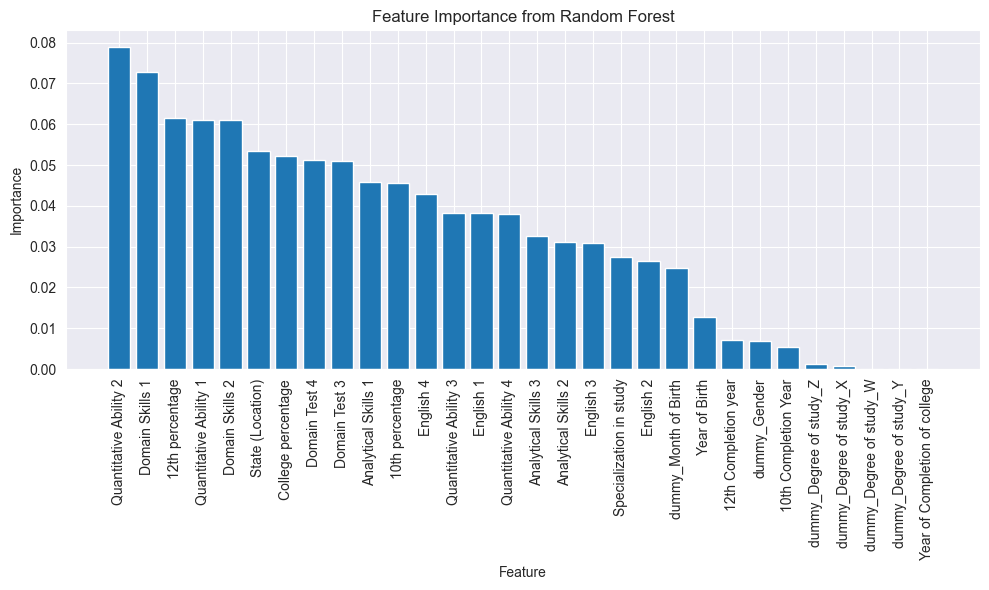

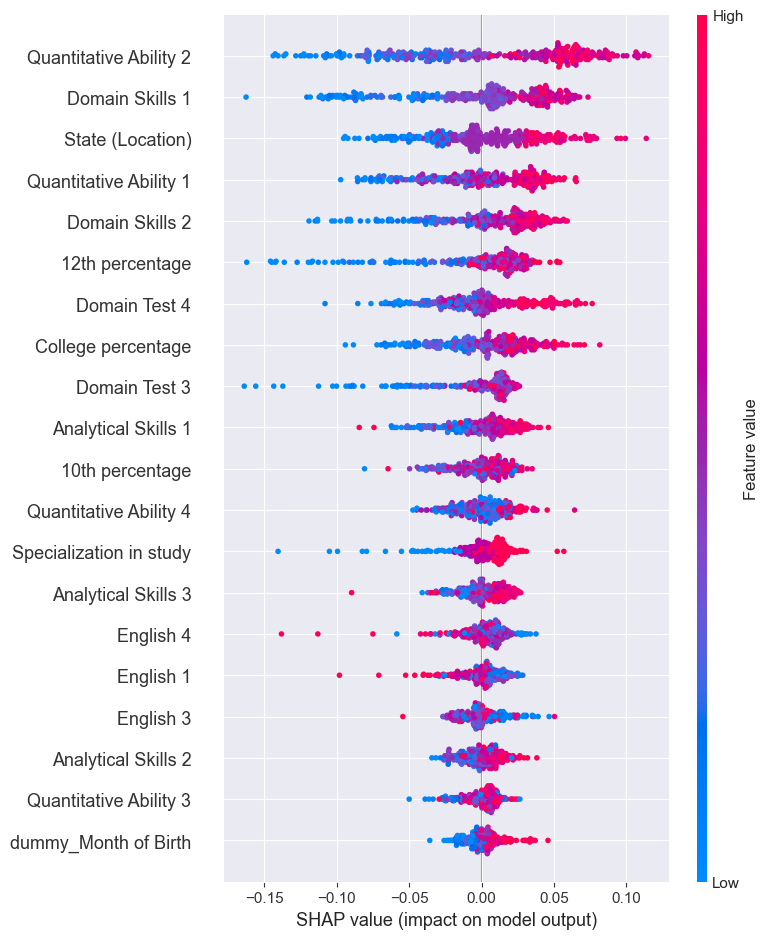

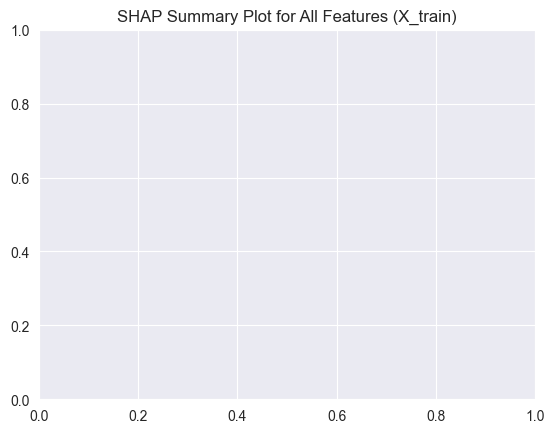

(RandomForestClassifier(random_state=42),
 .values =
 array([[[-0.00012619,  0.00012619],
         [-0.01981115,  0.01981115],
         [-0.01951857,  0.01951857],
         ...,
         [-0.000115  ,  0.000115  ],
         [-0.00534484,  0.00534484],
         [-0.06164869,  0.06164869]],
 
        [[-0.00926964,  0.00926964],
         [-0.03367913,  0.03367913],
         [ 0.01910052, -0.01910052],
         ...,
         [-0.00017167,  0.00017167],
         [-0.01858393,  0.01858393],
         [ 0.0079519 , -0.0079519 ]],
 
        [[-0.00967496,  0.00967496],
         [-0.02785218,  0.02785218],
         [ 0.00973202, -0.00973202],
         ...,
         [-0.00014667,  0.00014667],
         [-0.01330298,  0.01330298],
         [ 0.03693194, -0.03693194]],
 
        ...,
 
        [[-0.00428766,  0.00428766],
         [-0.01866976,  0.01866976],
         [-0.03430591,  0.03430591],
         ...,
         [-0.00022595,  0.00022595],
         [-0.00716571,  0.00716571],
         [-0.008

In [109]:
evaluate_random_forest_with_shap(df, classification_columns, smooth_target_encoding, y_column=y_column, test_size=0.2, random_state=42)

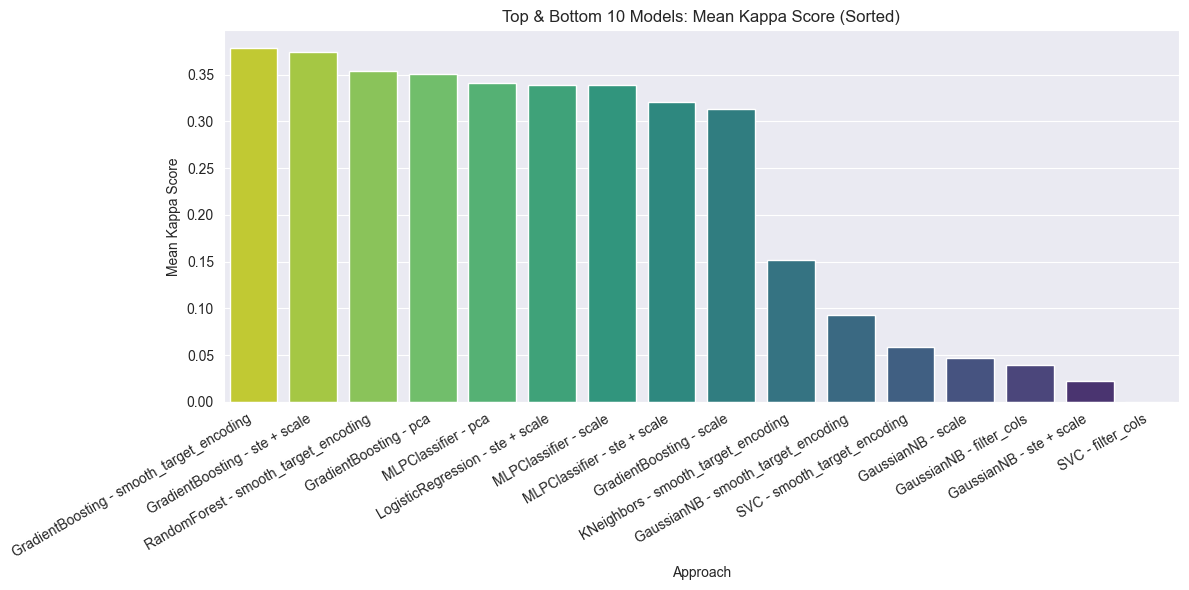

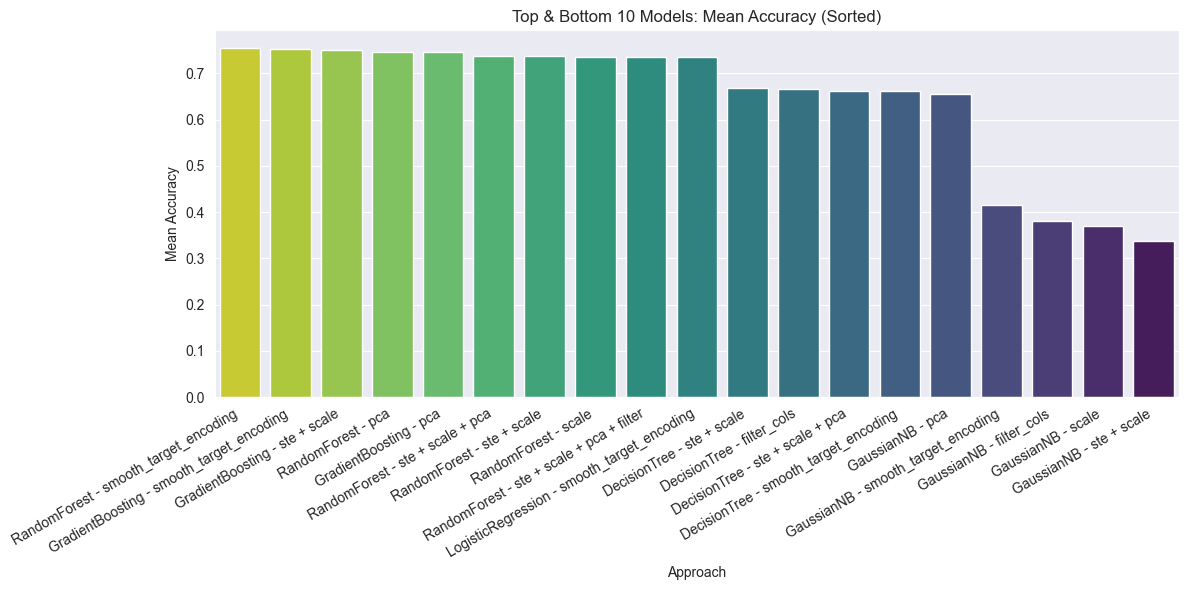

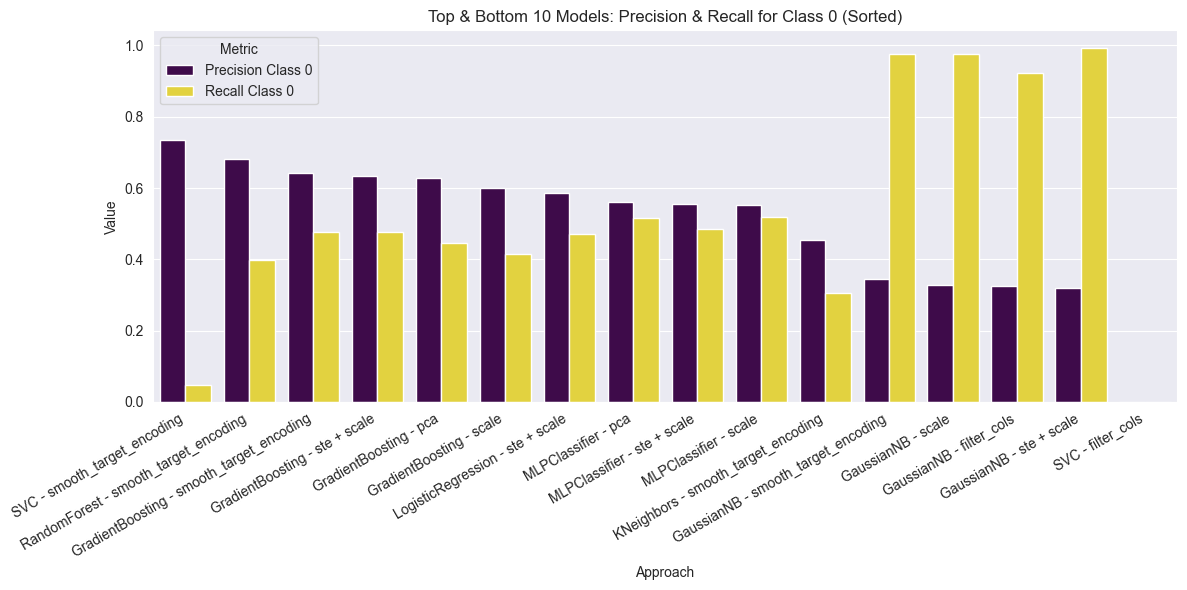

In [108]:
plot_model_results(model_results_df)